Total dataset length: 9999
Train dataset length: 5999
Validation dataset length: 1999
Test dataset length: 2001
First images:


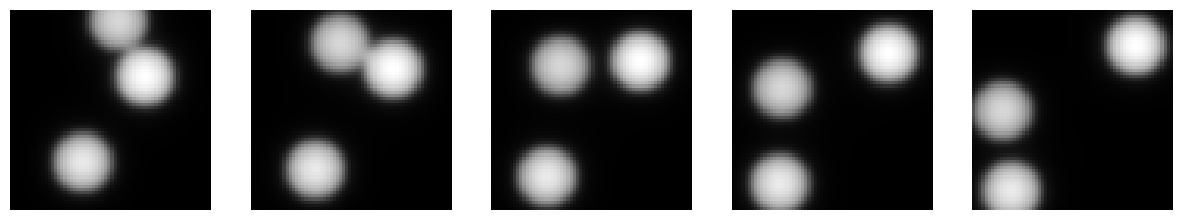

Next images:


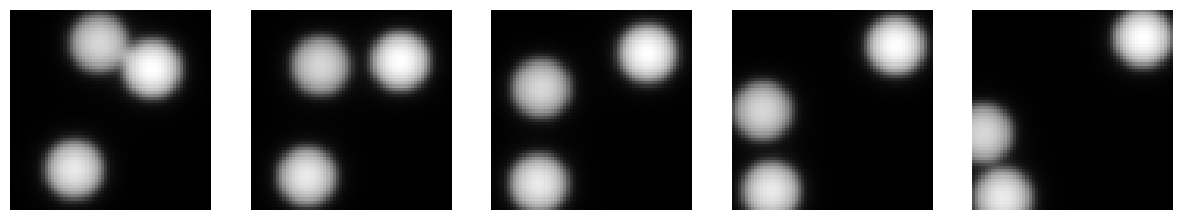

torch.Size([16, 1, 64, 64]) torch.Size([16, 1, 64, 64])


In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import matplotlib.pyplot as plt

class CustomDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.png')], key=lambda x: int(x.split('_')[1].split('.')[0]))
        self.transform = transform

    def __len__(self):
        return len(self.image_files) - 1  # Subtract 1 because the last image has no next image

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx])
        next_img_name = os.path.join(self.image_dir, self.image_files[idx + 1])
        
        image = Image.open(img_name).convert('L')  # Convert image to grayscale
        next_image = Image.open(next_img_name).convert('L')  # Convert next image to grayscale
        
        if self.transform:
            image = self.transform(image)
            next_image = self.transform(next_image)
        
        return image, next_image

# Define the directory where images are stored
image_dir = 'images_10000_3'

# Define transformations (if any)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Create the dataset
dataset = CustomDataset(image_dir=image_dir, transform=transform)

# Print the length of the dataset
print(f"Total dataset length: {len(dataset)}")

# Calculate lengths for train, val, test datasets
total_len = len(dataset)
train_len = int(0.6 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len

# Print the lengths of the train, val, and test datasets
print(f"Train dataset length: {train_len}")
print(f"Validation dataset length: {val_len}")
print(f"Test dataset length: {test_len}")

# Create subsets manually by indices
train_indices = list(range(0, train_len))
val_indices = list(range(train_len, train_len + val_len))
test_indices = list(range(train_len + val_len, total_len))

train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Function to display images
def show_images(images, nrow=1, ncol=5):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 3))
    for i in range(ncol):
        ax = axes[i]
        ax.imshow(images[i].squeeze(), cmap='gray')
        ax.axis('off')
    plt.show()

# Display the first five pairs of images in the dataset
if __name__ == '__main__':
    # Display the first five pairs of images
    first_five_pairs = [dataset[i] for i in range(5)]
    first_images = [pair[0] for pair in first_five_pairs]
    next_images = [pair[1] for pair in first_five_pairs]
    
    print("First images:")
    show_images(first_images)
    
    print("Next images:")
    show_images(next_images)
    
    # Example usage of data loaders
    for images, targets in train_loader:
        print(images.size(), targets.size())  # Example output: torch.Size([64, 1, H, W]) torch.Size([64, 1, H, W])
        break


In [4]:
import torch
import torch.nn as nn

class SimpleLinearNetwork(nn.Module):
    def __init__(self):
        super(SimpleLinearNetwork, self).__init__()
        self.flatten = nn.Flatten()  # 将输入展平
        self.linear = nn.Linear(64 * 64, 256)  # 一个线性层

    def forward(self, x):
        x = self.flatten(x)  # 展平输入
        x = self.linear(x)  # 线性层变换
        return x

# 示例张量 (B, 1, 64, 64)
input_tensor = torch.randn(8, 1, 64, 64)  # 这里 B = 8 作为示例

# 创建网络实例
model = SimpleLinearNetwork()

# 前向传播
output_tensor = model(input_tensor)
print(output_tensor.shape)  # 期望输出 (B, 256)，这里 B = 8

torch.Size([8, 256])


In [5]:
import torch
import torch.nn as nn

class Time2Vec(nn.Module):
    def __init__(self, seq_len):
        super(Time2Vec, self).__init__()
        self.seq_len = seq_len
        self.weights_linear = nn.Parameter(torch.Tensor(seq_len // 2))
        self.bias_linear = nn.Parameter(torch.Tensor(seq_len // 2))
        self.weights_periodic = nn.Parameter(torch.Tensor(seq_len // 2))
        self.bias_periodic = nn.Parameter(torch.Tensor(seq_len // 2))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.uniform_(self.weights_linear)
        nn.init.uniform_(self.bias_linear)
        nn.init.uniform_(self.weights_periodic)
        nn.init.uniform_(self.bias_periodic)

    def forward(self, x):
        x_mean = torch.mean(x, dim=-1, keepdim=True)  # (B, 256) -> (B, 1)
        
        # 线性时间嵌入
        time_linear = self.weights_linear * x_mean + self.bias_linear  # (B, 1) -> (B, 128)
        
        # 周期性时间嵌入
        time_periodic = torch.sin(self.weights_periodic * x_mean + self.bias_periodic)  # (B, 1) -> (B, 128)
        
        # 拼接线性和周期性时间嵌入
        time_embedding = torch.cat([time_linear, time_periodic], dim=-1)  # (B, 128) and (B, 128) -> (B, 256)
        
        # 残差连接，将输入x与时间嵌入拼接
        residual_connection = torch.cat([x, time_embedding], dim=-1)  # (B, 256) and (B, 256) -> (B, 512)
        
        return residual_connection

# 示例用法
input_tensor = torch.randn(32, 256)  # (B, 256)
model = Time2Vec(seq_len=256)
output_tensor = model(input_tensor)  # (B, 512)

print(output_tensor.shape)  # 应输出: torch.Size([32, 512])

torch.Size([32, 512])


In [6]:
import torch
import torch.nn as nn

class SingleAttentionHead(nn.Module):
    def __init__(self, input_dim, d_k, d_v):
        super(SingleAttentionHead, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

        self.W_Q = nn.Linear(input_dim, d_k)  # (input_dim, d_k)
        self.W_K = nn.Linear(input_dim, d_k)  # (input_dim, d_k)
        self.W_V = nn.Linear(input_dim, d_v)  # (input_dim, d_v)
        self.softmax = nn.Softmax(dim=-1)  # 使用 nn.Softmax

    def forward(self, X):
        # X: (B, input_dim)
        Q = self.W_Q(X)  # (B, d_k)
        K = self.W_K(X)  # (B, d_k)
        V = self.W_V(X)  # (B, d_v)

        # scores: (B, B)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))  
        
        # attention_weights: (B, B)
        attention_weights = self.softmax(scores)
        
        # attention_output: (B, d_v)
        attention_output = torch.matmul(attention_weights, V)  

        return attention_output

# 示例使用
B = 32  # 批次大小
input_dim = 512  # 输入维度
d_k = 64
d_v = 128

# 随机生成输入张量
X = torch.randn(B, input_dim)

# 创建注意力头实例
attention_head = SingleAttentionHead(input_dim, d_k, d_v)

# 前向传播
output = attention_head(X)

print("Attention Output Shape:", output.shape)  # 输出应为 (B, d_v)

Attention Output Shape: torch.Size([32, 128])


In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, num_heads, d_k, d_v):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_k = d_k
        self.d_v = d_v

        # 创建多个注意力头，每个注意力头都是一个SingleAttentionHead实例
        self.attention_heads = nn.ModuleList([SingleAttentionHead(input_dim, d_k, d_v) for _ in range(num_heads)])
        self.W_O = nn.Linear(num_heads * d_v, input_dim)  # (num_heads * d_v, input_dim)


    def forward(self, X):
        # X: (B, input_dim)
        
        # 获取所有头的注意力输出，列表中的每个元素形状为 (B, d_v)
        attention_outputs = [head(X) for head in self.attention_heads]
        
        # 拼接所有头的输出，结果形状为 (B, num_heads * d_v)
        concat_output = torch.cat(attention_outputs, dim=-1)
        
        # 通过线性变换，最终输出形状为 (B, input_dim)
        output = self.W_O(concat_output)
        
        return output

# 示例使用
B = 32  # 批次大小
input_dim = 512  # 输入维度
num_heads = 32  # 头的数量
d_k = 64
d_v = 128

# 随机生成输入张量
X = torch.randn(B, input_dim)

# 创建多头注意力实例
multi_head_attention = MultiHeadAttention(input_dim, num_heads, d_k, d_v)

# 前向传播
output = multi_head_attention(X)

print("Multi-Head Attention Output Shape:", output.shape)  # 输出应为 (B, input_dim)

Multi-Head Attention Output Shape: torch.Size([32, 512])


In [8]:
import torch
import torch.nn as nn

class ProcessingModule(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=2048, dropout_rate=0.1):
        super(ProcessingModule, self).__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.norm1 = nn.LayerNorm(input_dim)
        self.feed_forward = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
        self.norm2 = nn.LayerNorm(input_dim)

    def forward(self, x):
        # Residual connection around dropout and normalization
        residual = x
        x = self.dropout(x)
        x = self.norm1(x + residual)
        
        # Feed-forward network
        x = self.feed_forward(x)
        
        # Add residual connection and apply final normalization
        x = self.norm2(x + residual)
        
        return x

# Example usage
batch_size = 32  # Example batch size
input_tensor = torch.randn((batch_size, 512))  # replace batch_size with your batch size
model = ProcessingModule()
output = model(input_tensor)

print("Output shape:", output.shape)  # Print output shape

Output shape: torch.Size([32, 512])


In [8]:
class CombinedNetwork(nn.Module):
    def __init__(self, seq_len, input_dim, num_heads, d_k, d_v):
        super(CombinedNetwork, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # (B, 1, 64, 64) -> (B, 16, 32, 32)
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # (B, 16, 32, 32) -> (B, 32, 16, 16)
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),  # (B, 32, 16, 16) -> (B, 64, 8, 8)
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 512)  # (B, 64*8*8) -> (B, 512)
        )
        
        self.latent = nn.Sequential(
            MultiHeadAttention(input_dim, num_heads, d_k, d_v),
            ProcessingModule(input_dim=input_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(512, 64 * 8 * 8),  # (B, 512) -> (B, 64*8*8)
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 64, 8, 8) -> (B, 32, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 32, 16, 16) -> (B, 16, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 16, 32, 32) -> (B, 1, 64, 64)
            nn.Sigmoid()  # Ensure the output values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.latent(x)
        x = self.decoder(x)
        return x

# 示例使用
seq_len = 256
input_dim = 512
num_heads = 32
d_k = 64
d_v = 128

model = CombinedNetwork(seq_len, input_dim, num_heads, d_k, d_v)
sample_input = torch.randn((32, 1, 64, 64))  # 假设输入是32个64x64的单通道图像
output = model(sample_input)
print(output.shape)  # 输出形状

torch.Size([32, 1, 64, 64])


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

seq_len = 256
input_dim = 512
num_heads = 32
d_k = 64
d_v = 128

# Initialize the autoencoder, loss function and optimizer
autoencoder = CombinedNetwork(seq_len, input_dim, num_heads, d_k, d_v).to(device)

# Load pretrained weights for encoder and decoder
autoencoder.encoder.load_state_dict(torch.load('best_encoder_1.pth'))
autoencoder.decoder.load_state_dict(torch.load('best_decoder_1.pth'))

# Freeze encoder and decoder
for param in autoencoder.encoder.parameters():
    param.requires_grad = False

for param in autoencoder.decoder.parameters():
    param.requires_grad = False

criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, autoencoder.parameters()), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=20, verbose=False, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Training function
def train_autoencoder(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, patience=20):
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='best_model_3_4_1.pth')
    model.train()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Adjust learning rate based on validation loss
        scheduler.step(avg_val_loss)

        # Check early stopping condition
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    model.load_state_dict(torch.load('best_model_3_4_1.pth'))
    
    # Print the best validation loss
    print(f'Best Validation Loss: {early_stopping.val_loss_min:.4f}')
    
    return model

# Evaluation function
def evaluate_autoencoder(model, dataloader):
    model.eval()
    original_images = []
    reconstructed_images = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            original_images.extend(targets.cpu())
            reconstructed_images.extend(outputs.cpu())
            break  # Remove this line if you want to evaluate the whole dataset
    return original_images, reconstructed_images

# Assume train_loader, val_loader, and test_loader are defined and loaded elsewhere

# Train the autoencoder with early stopping
autoencoder = train_autoencoder(autoencoder, train_loader, val_loader, criterion, optimizer, scheduler, epochs=2000, patience=20)

# Evaluate the autoencoder
original_images, reconstructed_images = evaluate_autoencoder(autoencoder, test_loader)

Using device: cuda


c:\Users\metho\anaconda3\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Epoch [1/2000], Train Loss: 0.0551, Val Loss: 0.0480
Validation loss decreased (inf --> 0.047991).  Saving model ...
Epoch [2/2000], Train Loss: 0.0454, Val Loss: 0.0431
Validation loss decreased (0.047991 --> 0.043078).  Saving model ...
Epoch [3/2000], Train Loss: 0.0416, Val Loss: 0.0405
Validation loss decreased (0.043078 --> 0.040478).  Saving model ...
Epoch [4/2000], Train Loss: 0.0393, Val Loss: 0.0386
Validation loss decreased (0.040478 --> 0.038603).  Saving model ...
Epoch [5/2000], Train Loss: 0.0374, Val Loss: 0.0371
Validation loss decreased (0.038603 --> 0.037147).  Saving model ...
Epoch [6/2000], Train Loss: 0.0359, Val Loss: 0.0359
Validation loss decreased (0.037147 --> 0.035943).  Saving model ...
Epoch [7/2000], Train Loss: 0.0345, Val Loss: 0.0349
Validation loss decreased (0.035943 --> 0.034928).  Saving model ...
Epoch [8/2000], Train Loss: 0.0333, Val Loss: 0.0340
Validation loss decreased (0.034928 --> 0.033962).  Saving model ...
Epoch [9/2000], Train Loss: 0

Using device: cuda


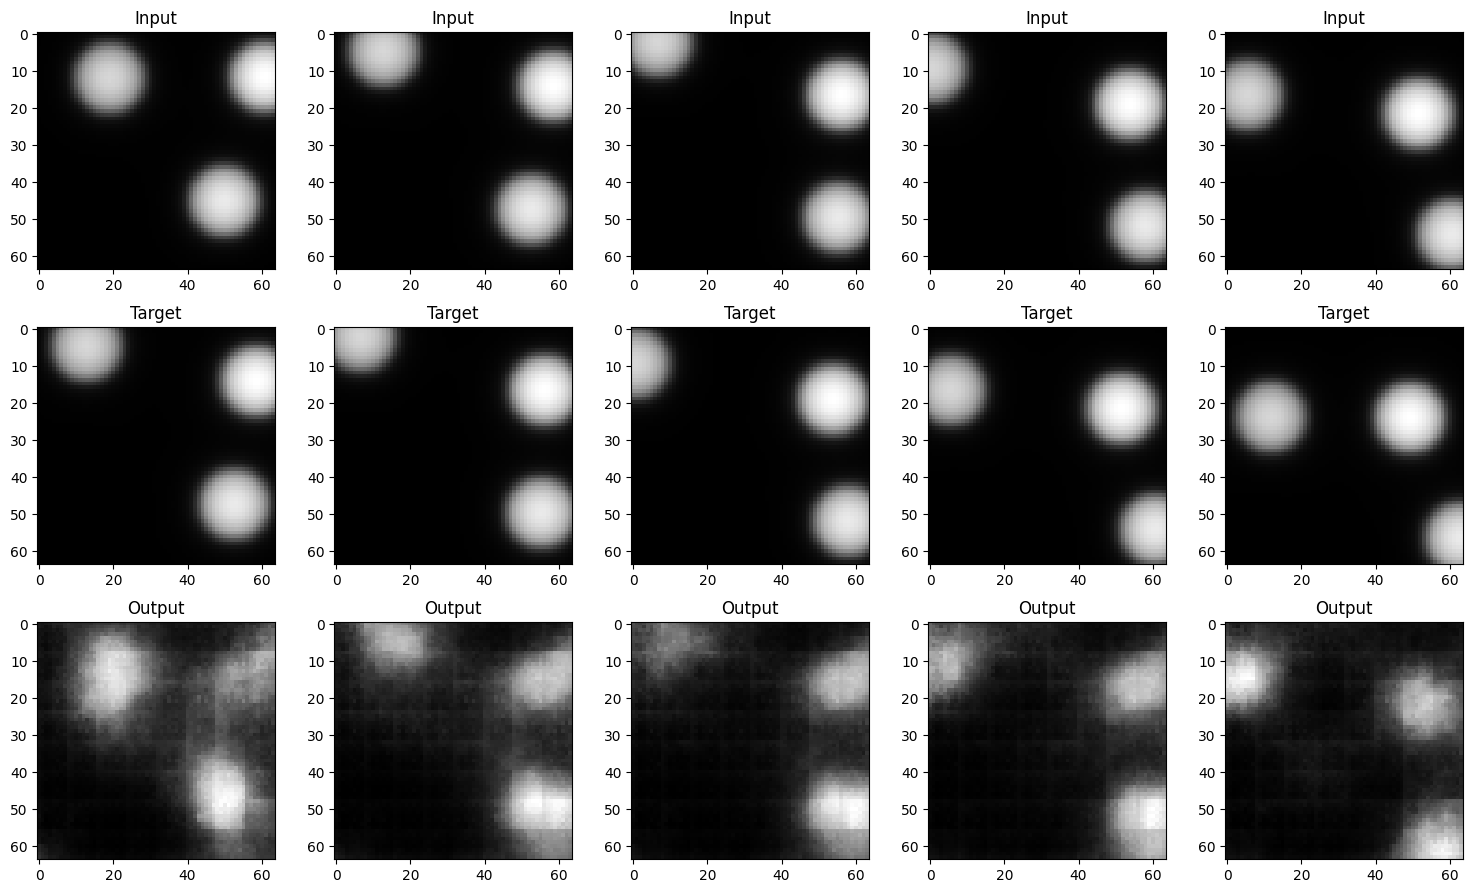

In [10]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

seq_len = 256
input_dim = 512
num_heads = 32
d_k = 64
d_v = 128

# Initialize the autoencoder, loss function
autoencoder = CombinedNetwork(seq_len, input_dim, num_heads, d_k, d_v).to(device)
criterion = nn.MSELoss()

# Function to load the model
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.to(device)

# Function to visualize images
def visualize_images(model, data_loader):
    model.eval()
    inputs, targets = next(iter(data_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        outputs = model(inputs)
    
    inputs = inputs.cpu().numpy()
    targets = targets.cpu().numpy()
    outputs = outputs.cpu().numpy()
    
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    for i in range(5):
        axes[0, i].imshow(inputs[i][0], cmap='gray')
        axes[0, i].set_title("Input")
        axes[1, i].imshow(targets[i][0], cmap='gray')
        axes[1, i].set_title("Target")
        axes[2, i].imshow(outputs[i][0], cmap='gray')
        axes[2, i].set_title("Output")
    
    plt.tight_layout()
    plt.show()

# Load the trained model
load_model(autoencoder, 'best_model_3_4_1.pth')

# Visualize the results on validation data
visualize_images(autoencoder, val_loader)

In [9]:
class CombinedNetwork(nn.Module):
    def __init__(self, seq_len, input_dim, num_heads, d_k, d_v):
        super(CombinedNetwork, self).__init__()
        
        self.encoder = nn.Sequential(
            SimpleLinearNetwork(),
            Time2Vec(seq_len),
            MultiHeadAttention(input_dim, num_heads, d_k, d_v),
            ProcessingModule(input_dim=input_dim)
        )
        
        self.latent = nn.Sequential(
            MultiHeadAttention(input_dim, num_heads, d_k, d_v),
            ProcessingModule(input_dim=input_dim)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(512, 64 * 8 * 8),  # (B, 512) -> (B, 64*8*8)
            nn.Unflatten(1, (64, 8, 8)),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 64, 8, 8) -> (B, 32, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 32, 16, 16) -> (B, 16, 32, 32)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # (B, 16, 32, 32) -> (B, 1, 64, 64)
            nn.Sigmoid()  # Ensure the output values are between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.latent(x)
        x = self.decoder(x)
        return x

# 示例使用
seq_len = 256
input_dim = 512
num_heads = 32
d_k = 64
d_v = 128

model = CombinedNetwork(seq_len, input_dim, num_heads, d_k, d_v)
sample_input = torch.randn((32, 1, 64, 64))  # 假设输入是32个64x64的单通道图像
output = model(sample_input)
print(output.shape)  # 输出形状

torch.Size([32, 1, 64, 64])


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

seq_len = 256
input_dim = 512
num_heads = 32
d_k = 64
d_v = 128

# Initialize the autoencoder, loss function and optimizer
autoencoder = CombinedNetwork(seq_len, input_dim, num_heads, d_k, d_v).to(device)

# Load pretrained weights for encoder and decoder
autoencoder.encoder.load_state_dict(torch.load('best_encoder_2.pth'))
autoencoder.decoder.load_state_dict(torch.load('best_decoder_2.pth'))

# Freeze encoder and decoder
for param in autoencoder.encoder.parameters():
    param.requires_grad = False

for param in autoencoder.decoder.parameters():
    param.requires_grad = False

criterion = nn.MSELoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, autoencoder.parameters()), lr=0.00001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=20, verbose=False, delta=0, path='checkpoint.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

# Function to save the model
def save_model(model, path):
    torch.save(model.state_dict(), path)

# Training function
def train_autoencoder(model, train_loader, val_loader, criterion, optimizer, scheduler, epochs, patience=20):
    early_stopping = EarlyStopping(patience=patience, verbose=True, path='best_model_3_4_2.pth')
    model.train()

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
        avg_train_loss = running_loss / len(train_loader)

        # Validation step
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Adjust learning rate based on validation loss
        scheduler.step(avg_val_loss)

        # Check early stopping condition
        early_stopping(avg_val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    # Load the best model
    model.load_state_dict(torch.load('best_model_3_4_2.pth'))
    
    # Print the best validation loss
    print(f'Best Validation Loss: {early_stopping.val_loss_min:.4f}')
    
    return model

# Evaluation function
def evaluate_autoencoder(model, dataloader):
    model.eval()
    original_images = []
    reconstructed_images = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            original_images.extend(targets.cpu())
            reconstructed_images.extend(outputs.cpu())
            break  # Remove this line if you want to evaluate the whole dataset
    return original_images, reconstructed_images

# Assume train_loader, val_loader, and test_loader are defined and loaded elsewhere

# Train the autoencoder with early stopping
autoencoder = train_autoencoder(autoencoder, train_loader, val_loader, criterion, optimizer, scheduler, epochs=2000, patience=20)

# Evaluate the autoencoder
original_images, reconstructed_images = evaluate_autoencoder(autoencoder, test_loader)



Using device: cuda
Epoch [1/2000], Train Loss: 0.0558, Val Loss: 0.0495
Validation loss decreased (inf --> 0.049522).  Saving model ...
Epoch [2/2000], Train Loss: 0.0485, Val Loss: 0.0476
Validation loss decreased (0.049522 --> 0.047586).  Saving model ...
Epoch [3/2000], Train Loss: 0.0467, Val Loss: 0.0466
Validation loss decreased (0.047586 --> 0.046589).  Saving model ...
Epoch [4/2000], Train Loss: 0.0457, Val Loss: 0.0461
Validation loss decreased (0.046589 --> 0.046110).  Saving model ...
Epoch [5/2000], Train Loss: 0.0451, Val Loss: 0.0457
Validation loss decreased (0.046110 --> 0.045717).  Saving model ...
Epoch [6/2000], Train Loss: 0.0445, Val Loss: 0.0454
Validation loss decreased (0.045717 --> 0.045372).  Saving model ...
Epoch [7/2000], Train Loss: 0.0440, Val Loss: 0.0452
Validation loss decreased (0.045372 --> 0.045153).  Saving model ...
Epoch [8/2000], Train Loss: 0.0436, Val Loss: 0.0449
Validation loss decreased (0.045153 --> 0.044876).  Saving model ...
Epoch [9/2

Using device: cuda


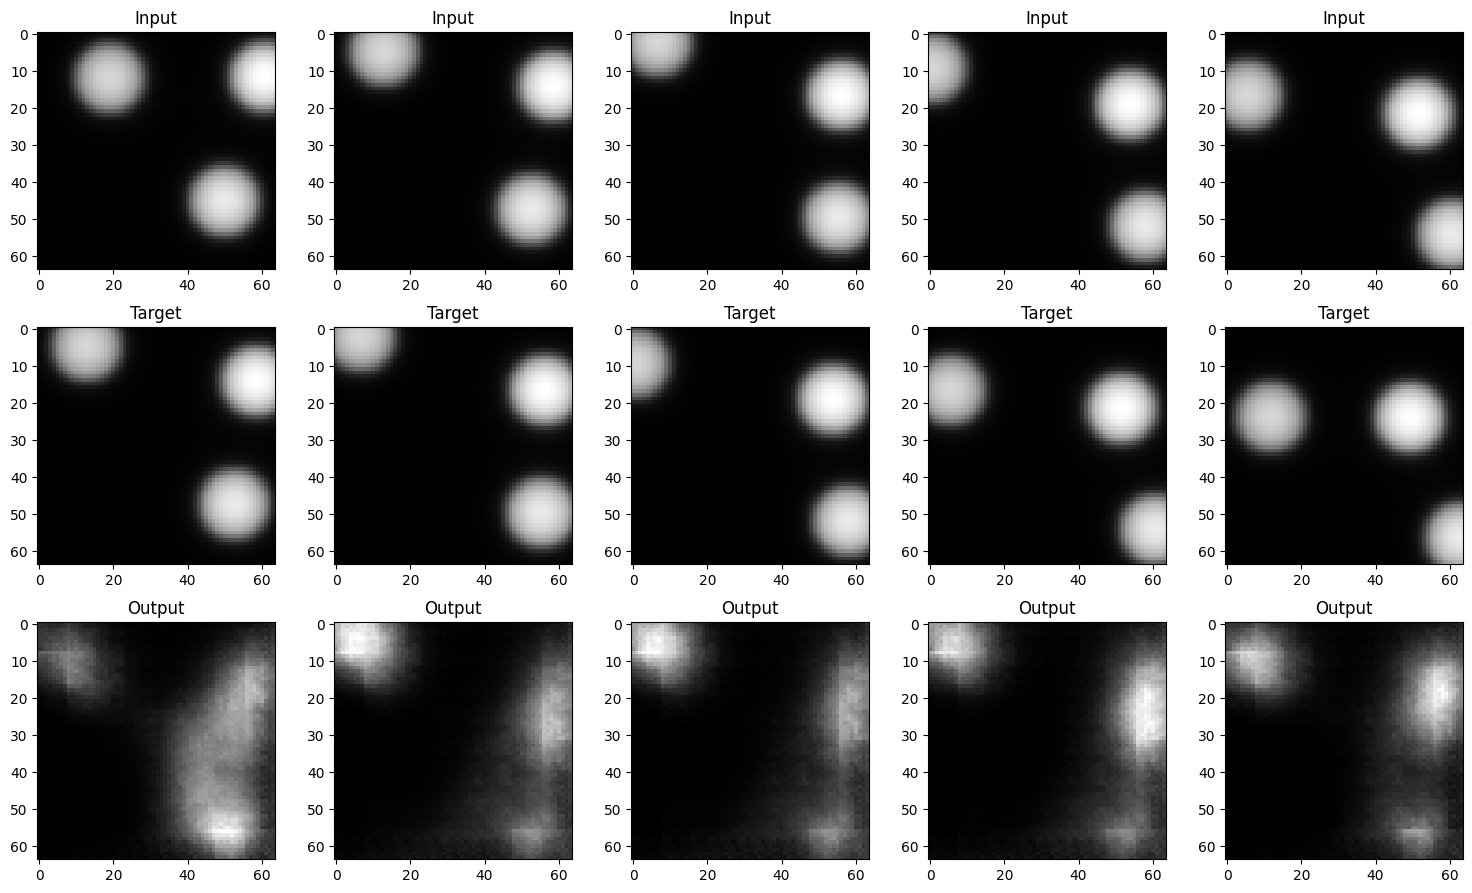

In [13]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

seq_len = 256
input_dim = 512
num_heads = 32
d_k = 64
d_v = 128

# Initialize the autoencoder, loss function
autoencoder = CombinedNetwork(seq_len, input_dim, num_heads, d_k, d_v).to(device)
criterion = nn.MSELoss()

# Function to load the model
def load_model(model, model_path):
    model.load_state_dict(torch.load(model_path))
    model.to(device)

# Function to visualize images
def visualize_images(model, data_loader):
    model.eval()
    inputs, targets = next(iter(data_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    with torch.no_grad():
        outputs = model(inputs)
    
    inputs = inputs.cpu().numpy()
    targets = targets.cpu().numpy()
    outputs = outputs.cpu().numpy()
    
    fig, axes = plt.subplots(3, 5, figsize=(15, 9))
    for i in range(5):
        axes[0, i].imshow(inputs[i][0], cmap='gray')
        axes[0, i].set_title("Input")
        axes[1, i].imshow(targets[i][0], cmap='gray')
        axes[1, i].set_title("Target")
        axes[2, i].imshow(outputs[i][0], cmap='gray')
        axes[2, i].set_title("Output")
    
    plt.tight_layout()
    plt.show()

# Load the trained model
load_model(autoencoder, 'best_model_3_4_2.pth')

# Visualize the results on validation data
visualize_images(autoencoder, val_loader)
